Creating a connection to the planetary Dataset

In [1]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

asset = catalog.get_collection("gridmet").assets["zarr-abfs"]
asset

<Asset href=abfs://gridmet/gridmet.zarr>

Using xarray to read it:

In [2]:
import xarray as xr

ds = xr.open_zarr(
    asset.href,
    storage_options=asset.extra_fields["xarray:storage_options"],
    **asset.extra_fields["xarray:open_kwargs"]
)
ds

<xarray.Dataset>
Dimensions:                                    (time: 15341, lat: 585,
                                                lon: 1386, crs: 1)
Coordinates:
  * crs                                        (crs) uint16 3
  * lat                                        (lat) float64 49.4 ... 25.07
  * lon                                        (lon) float64 -124.8 ... -67.06
  * time                                       (time) datetime64[ns] 1979-01-...
Data variables:
    air_temperature                            (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    burning_index_g                            (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    dead_fuel_moisture_1000hr                  (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    dead_fuel_moisture_100hr                   (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    mean_vapor_pressure_deficit                (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    potential_evapotranspiration               (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    precipitation_amount                       (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    relative_humidity                          (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    specific_humidity                          (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    surface_downwelling_shortwave_flux_in_air  (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    wind_from_direction                        (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    wind_speed                                 (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.6
    author:                     John Abatzoglou - University of Idaho, jabatz...
    coordinate_system:          EPSG:4326
    date:                       02 July 2019
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_bounds_crs:      EPSG:4326
    ...                         ...
    geospatial_lon_units:       decimal_degrees east
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

This results in:
- 12 climate variables (e.g., Wind speed, direction, precipitation...)
- 15341 time points in 585 latitudes and 1386 longitudes

# Dataset Size

In [5]:
# Step 1: Slice the dataset for 2020

ds_2020 = ds.sel(time=slice("2020-01-01", "2020-12-31"))

# Step 2: Estimate memory usage by summing sizes of Dask arrays (in bytes)
total_bytes = sum(v.data.nbytes for v in ds_2020.data_vars.values())

# Convert to megabytes (or gigabytes)
total_MB = total_bytes / 1e6
total_GB = total_bytes / 1e9

print(f"Estimated size for 2020: {total_MB:.2f} MB ({total_GB:.2f} GB)")


Estimated size for 2020: 14244.31 MB (14.24 GB)


In [8]:
import pandas as pd

# List of years to evaluate
years = list(range(1979, 2021))

# Initialize list to collect sizes
size_info = []

# Iterate over years and estimate memory size
for year in years:
    # Slice dataset for the given year
    ds_year = ds.sel(time=slice(f"{year}-01-01", f"{year}-12-31"))

    # Sum of all Dask array sizes in bytes
    total_bytes = sum(v.data.nbytes for v in ds_year.data_vars.values())

    size_info.append({
        "year": year,
        "yearly_size_GB": total_bytes / 1e9
    })

# Create DataFrame
df_sizes = pd.DataFrame(size_info)

# Sort descending and compute cumulative size
df_sizes = df_sizes.sort_values("year", ascending=False)
df_sizes["cumulative_size_GB"] = df_sizes["yearly_size_GB"].cumsum()

# Optional: sort back by year ascending
df_sizes = df_sizes.sort_values("year")

In [13]:
df_sizes.sort_values("year", ascending=False)

,year,yearly_size_GB,cumulative_size_GB
41,2020,14.244310,14.244310
40,2019,14.205391,28.449701
39,2018,14.205391,42.655092
38,2017,14.205391,56.860484
37,2016,14.244310,71.104794
36,2015,14.205391,85.310185
35,2014,14.205391,99.515576
34,2013,14.205391,113.720967
33,2012,14.244310,127.965277
32,2011,14.205391,142.170669


We are talking about 14 GB aprox of data per year slice!!

Let's check about one month in 2020, just to interact with the data:

In [15]:
# Step 1: Slice the dataset for 2020

ds_2020_01 = ds.sel(time=slice("2020-01-01", "2020-01-31"))

# Step 2: Estimate memory usage by summing sizes of Dask arrays (in bytes)
total_bytes = sum(v.data.nbytes for v in ds_2020_01.data_vars.values())

# Convert to megabytes (or gigabytes)
total_MB = total_bytes / 1e6
total_GB = total_bytes / 1e9

print(f"Estimated size for 2020-01: {total_MB:.2f} MB ({total_GB:.2f} GB)")

Estimated size for 2020-01: 1206.49 MB (1.21 GB)


In [ ]:
import pandas as pd


# Step 2: Filter by time - all of 2020-01
ds_2020_01 = ds.sel(time=slice("2020-01-01", "2020-01-31"))

# Step 3: Optionally, choose a subset of variables (e.g., 'pr' for precipitation, 'tmmx' for max temp)
# For full dataset, skip the selection
# ds_2020 = ds_2020[['pr', 'tmmx']]  # example variable selection

# Step 4: Convert to DataFrame (long format)
ds_2020_01 = ds_2020_01.to_dataframe().reset_index()

In [17]:
ds_2020_01

,time,lat,lon,crs,air_temperature,burning_index_g,dead_fuel_moisture_1000hr,dead_fuel_moisture_100hr,mean_vapor_pressure_deficit,potential_evapotranspiration,precipitation_amount,relative_humidity,specific_humidity,surface_downwelling_shortwave_flux_in_air,wind_from_direction,wind_speed
0,2020-01-01,49.400000,-124.766667,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,49.400000,-124.725000,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,49.400000,-124.683333,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-01,49.400000,-124.641667,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01,49.400000,-124.600000,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25135105,2020-01-31,25.066667,-67.225000,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25135106,2020-01-31,25.066667,-67.183333,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25135107,2020-01-31,25.066667,-67.141667,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25135108,2020-01-31,25.066667,-67.100000,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


One month is 25M rows!!!

And most of them Have NaN information. Let's try to address this:

In [18]:
# List of metadata/coordinate columns to keep regardless of nulls
coord_cols = ["time", "lat", "lon", "crs"]

# Calculate threshold: drop rows with less than N non-null variables
min_valid_vars = 3  # adjust as needed based on your dataset

# Drop rows where the number of non-null variable values is less than threshold
df_drop_na = ds_2020_01.dropna(
    subset=[col for col in ds_2020_01.columns if col not in coord_cols],
    thresh=min_valid_vars
).reset_index(drop=True)

In [19]:
df_drop_na

,time,lat,lon,crs,air_temperature,burning_index_g,dead_fuel_moisture_1000hr,dead_fuel_moisture_100hr,mean_vapor_pressure_deficit,potential_evapotranspiration,precipitation_amount,relative_humidity,specific_humidity,surface_downwelling_shortwave_flux_in_air,wind_from_direction,wind_speed
0,2020-01-01,49.400000,-95.141667,3,269.399994,12.0,21.000000,23.000000,0.18,0.6,0.000000,48.100002,0.00110,54.100002,129.0,1.5
1,2020-01-01,49.400000,-95.100000,3,267.600006,8.0,22.400000,25.600000,0.11,0.4,0.300000,52.700001,0.00108,54.100002,126.0,1.4
2,2020-01-01,49.400000,-95.058333,3,267.799988,9.0,22.300001,25.500000,0.11,0.4,0.500000,51.600002,0.00108,54.200001,126.0,1.4
3,2020-01-01,49.400000,-95.016667,3,267.899994,9.0,22.200001,25.400000,0.12,0.4,0.600000,51.000000,0.00108,54.200001,126.0,1.4
4,2020-01-01,49.400000,-94.975000,3,268.000000,9.0,22.100000,25.200001,0.12,0.4,0.600000,50.600002,0.00108,54.200001,124.0,1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15000244,2020-01-31,25.066667,-80.558333,3,298.399994,0.0,19.900000,23.000000,0.39,3.2,34.299999,62.500000,0.01316,199.300003,126.0,2.6
15000245,2020-01-31,25.066667,-80.516667,3,299.299988,0.0,18.200001,21.800001,0.66,3.9,36.500000,58.200001,0.01304,199.400009,126.0,2.7
15000246,2020-01-31,25.066667,-80.475000,3,299.200012,0.0,18.200001,21.800001,0.64,3.8,32.799999,58.600002,0.01305,199.500000,130.0,2.7
15000247,2020-01-31,25.066667,-80.433333,3,299.200012,0.0,18.100000,21.600000,0.65,3.9,31.200001,58.900002,0.01311,199.600006,130.0,2.8


In [26]:
df_drop_na.isna().mean().sort_values(ascending=False)

time                                         0.0
lat                                          0.0
lon                                          0.0
crs                                          0.0
air_temperature                              0.0
burning_index_g                              0.0
dead_fuel_moisture_1000hr                    0.0
dead_fuel_moisture_100hr                     0.0
mean_vapor_pressure_deficit                  0.0
potential_evapotranspiration                 0.0
precipitation_amount                         0.0
relative_humidity                            0.0
specific_humidity                            0.0
surface_downwelling_shortwave_flux_in_air    0.0
wind_from_direction                          0.0
wind_speed                                   0.0
dtype: float64

## Animating air temperature

In [4]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter
import cartopy.crs as ccrs
import numpy as np
import numpy.ma

plt.style.use("dark_background")

Let's load a year's worth of data.

In [5]:
chunk = ds["air_temperature"][:30].compute()

In [6]:
chunk

<xarray.DataArray 'air_temperature' (time: 30, lat: 585, lon: 1386)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 49.4 49.36 49.32 49.28 ... 25.19 25.15 25.11 25.07
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -67.14 -67.1 -67.06
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-01-30
Attributes:
    coordinate_system:  WGS84,EPSG:4326
    description:        Daily Minimum Temperature
    dimensions:         lon lat time
    grid_mapping:       crs
    long_name:          tmmn
    standard_name:      tmmn
    units:              K

And now we can make the animation using matplotlib.animation.FuncAnimation. (not working yet)

FileNotFoundError: [WinError 2] El sistema no puede encontrar el archivo especificado

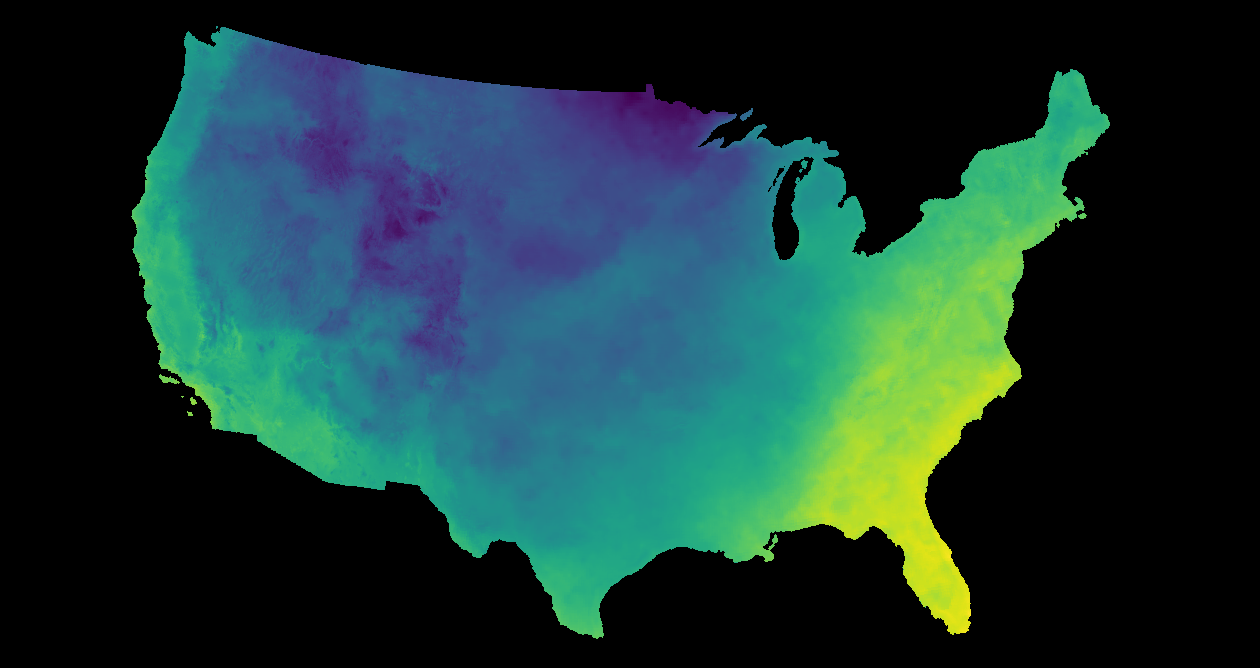

In [10]:
map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)

fig, ax = plt.subplots(figsize=(16, 9), subplot_kw=dict(projection=map_proj))
ax.set_axis_off()

quadmesh = chunk[0].plot(
    ax=ax, add_colorbar=False, add_labels=False, transform=ccrs.PlateCarree()
)

def animate(i):
    a = chunk[i].data.ravel()
    a2 = np.ma.array(a, mask=np.isnan(a))
    quadmesh.set_array(a2)
    return [quadmesh]

anim = animation.FuncAnimation(fig, animate, frames=len(chunk), interval=120)

# Setup FFMpeg writer
writer = FFMpegWriter(fps=15, extra_args=["-vcodec", "libx264"])

# Save animation using FFMpeg
anim.save("anim.mp4", writer=writer)

See the video (not working yet)

In [11]:
from IPython.display import Video

Video("anim.mp4")

ValueError: To embed videos, you must pass embed=True (this may make your notebook files huge)
Consider passing Video(url='...')